# Basic usage of the se2cnn library

This jupyter demo will contain the basic usage examples of the se2cnn library with applications to digit recognition in the MNIST dataset.

## Load the libraries

In [1]:
# Impor tensorflow and numpy
import tensorflow as tf
import numpy as np
import math as m
import time

# For plotting
from matplotlib import pyplot as plt

# Add the library to the system path
import os,sys
se2cnn_source =  os.path.join(os.getcwd(),'..')
if se2cnn_source not in sys.path:
    sys.path.append(se2cnn_source)

# Import the library
import se2cnn.layers
import se2cnn.rotation_matrix

## Load the MNIST dataset

The MNIS dataset consists of 28x28 images of handwritten characters. We are going to classify each input image into 1 of the 10 classes (the digits 0 to 9).

In [2]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


By default the data is formatted as flattened arrays. Here were format them as 2D feature maps (with only 1 channel).

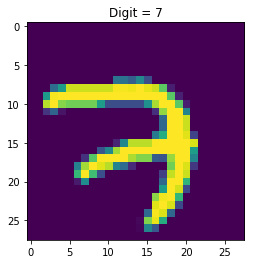

In [3]:
# Reshape to 2D multi-channel images
train_data_2D = train_data.reshape([len(train_data),28,28,1]) # [batch_size, Nx, Ny, Nc]
eval_data_2D = eval_data.reshape([len(eval_data),28,28,1])

# Plot the first sample
plt.plot()
plt.title('Digit = %d' % train_labels[0])
plt.imshow(train_data_2D[0,:,:,0])

## Build a graph

In [4]:
graph = tf.Graph()
graph.as_default()
tf.reset_default_graph()

### Settings

Kernel size and number of orientations

In [5]:
Ntheta = 8
Nx=Ny=5

### Placeholders

In [6]:
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,28,28,1] )
labels_ph = tf.placeholder( dtype = tf.int32, shape = [None,] )

### Prepare for the first layer

In [7]:
tensor_in = inputs_ph
Nc_in = 1

In [8]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)])

### Layer 1: The lifting layer

In [9]:
with tf.variable_scope("Layer_{}".format(1)) as _scope:
    ## Settings
    Nc_out = 6

    ## Perform convolution-max pooling-relu
    # Lifting layer
    tensor_out, kernels_raw, kernels_formatted = se2cnn.layers.z2_se2n(
                            input_tensor = tensor_in,
                            kernel_shape = [Nx, Ny, Nc_in, Nc_out],
                            orientations_nb = Ntheta)
    # Max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( tensor=tensor_out, nbOrientations=Ntheta)
    # ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out

Z2-SE2N KERNELS SHAPE: (8, 5, 5, 1, 6)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 8, 24, 24, 6)


In [10]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(8), Dimension(12), Dimension(12), Dimension(6)])

### Layer 2: SE2-conv, max-pool, relu

In [11]:
with tf.variable_scope("Layer_{}".format(2)) as _scope:
    ## Settings
    Nc_out = 16

    ## Perform convolution-max pooling-relu
    # Lifting layer
    tensor_out, kernels_raw, kernels_formatted = se2cnn.layers.se2n_se2n(
                            input_tensor = tensor_in,
                            kernel_shape = [5, 5, Nc_in, Nc_out],
                            orientations_nb = Ntheta)
    # Max-pooling
    tensor_out = se2cnn.layers.spatial_max_pool( tensor=tensor_out, nbOrientations=Ntheta)
    # ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out

SE2N-SE2N BASE KERNEL SHAPE: (8, 5, 5, 6, 16)
OUTPUT SE2N ACTIVATIONS SHAPE: (?, 8, 8, 8, 16)


In [12]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(8), Dimension(4), Dimension(4), Dimension(16)])

### Layer 3: Projection to 2D plane followed by fully connected layer

Maximum intensity projection over theta, and flatten to 1D vector per sample

In [13]:
tensor_in = tf.reduce_max( tensor_in, axis=1) #--> [BatchSize, Height, Width, ChannelsOut]        

Followed by fully connected convolution layer

In [14]:
with tf.variable_scope("Layer_{}".format(3)) as _scope:
    ## Settings
    Nc_out = 120

    ## Perform convolution-max pooling-relu
    # 2D convolution layer (fully connected)
    tensor_out, kernels_raw = se2cnn.layers.z2_z2( tensor_in , [4,4,Nc_in,Nc_out])
    
    # ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out

Z2-Z2 KERNEL SHAPE: (4, 4, 16, 120)
OUTPUT Z2 ACTIVATIONS SHAPE: (?, 1, 1, 120)


In [15]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(120)])

### Layer 4: fully connected

In [16]:
with tf.variable_scope("Layer_{}".format(4)) as _scope:
    ## Settings
    Nc_out = 84

    ## Perform convolution-max pooling-relu
    # 2D convolution layer (fully connected)
    tensor_out, kernels_raw = se2cnn.layers.z2_z2( tensor_in , [1,1,Nc_in,Nc_out])
    
    # ReLU
    tensor_out = tf.nn.relu(tensor_out)

    ## Prepare for the next layer
    tensor_in = tensor_out
    Nc_in = Nc_out

Z2-Z2 KERNEL SHAPE: (1, 1, 120, 84)
OUTPUT Z2 ACTIVATIONS SHAPE: (?, 1, 1, 84)


In [17]:
tensor_in.get_shape()

TensorShape([Dimension(None), Dimension(1), Dimension(1), Dimension(84)])

### Layer 5: fully connected to output

In [18]:
with tf.variable_scope("Layer_{}".format(5)) as _scope:
    ## Settings
    Nc_out = 10

    ## Perform convolution-max pooling-relu
    # 2D convolution layer (fully connected)
    tensor_out, kernels_raw = se2cnn.layers.z2_z2( tensor_in , [1,1,Nc_in,Nc_out])
    
    # The output logits
    logits = tensor_out[:,0,0,:]
    predictions = tf.argmax(input=logits, axis=1)
    probabilities = tf.nn.softmax(logits)

Z2-Z2 KERNEL SHAPE: (1, 1, 84, 10)
OUTPUT Z2 ACTIVATIONS SHAPE: (?, 1, 1, 10)


In [19]:
logits.get_shape()

TensorShape([Dimension(None), Dimension(10)])

### Define the loss and the optimizer

In [20]:
# Cross-entropy loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels_ph, logits=logits)

In [21]:
# Configure the Training Op (for TRAIN mode)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())

## Begin session

In [22]:
#-- Start the (GPU) session
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

## Optimization

In each epoch we pass over all input samples in batch sizes of batch_size

In [23]:
batch_size=128
n_epochs=10

Loop over the input stack in batch of size "batch_size".

In [24]:
for epoch_nr in range(n_epochs):
    loss_average = 0
    data = train_data_2D
    labels = train_labels
    # KBatch settings
    NItPerEpoch = m.floor(len(data)/batch_size) #number of iterations per epoch
    samples=np.random.permutation(len(data))
    # Loop over dataset
    tStart = time.time()
    for iteration in range(NItPerEpoch):
        feed_dict = {
                inputs_ph: np.array(data[samples[iteration*batch_size:(iteration+1)*batch_size]]),
                labels_ph: np.array(labels[samples[iteration*batch_size:(iteration+1)*batch_size]])
                }
        operators_output = session.run([ loss , train_op ], feed_dict)
        loss_average += operators_output[0]/NItPerEpoch
    tElapsed = time.time() - tStart
    print('Epoch ' , epoch_nr , ' finished... Average loss = ' , loss_average , ', time = ',tElapsed)

Epoch  0  finished... Average loss =  0.2657618205299674 , time =  38.73426127433777
Epoch  1  finished... Average loss =  0.06122371554157602 , time =  36.9645733833313
Epoch  2  finished... Average loss =  0.04195345913728651 , time =  36.78606295585632
Epoch  3  finished... Average loss =  0.033053749711209314 , time =  36.81812500953674
Epoch  4  finished... Average loss =  0.025597977867710342 , time =  36.971532583236694
Epoch  5  finished... Average loss =  0.022329220299702354 , time =  37.07286238670349
Epoch  6  finished... Average loss =  0.018559924176229828 , time =  37.02373194694519
Epoch  7  finished... Average loss =  0.016587892656473972 , time =  37.11591577529907
Epoch  8  finished... Average loss =  0.01463253839607112 , time =  37.55608773231506
Epoch  9  finished... Average loss =  0.01007095366540133 , time =  37.54104709625244


## Validation

In [25]:
batch_size = 1000
labels_pred = []
for i in range(round(len(eval_data_2D)/batch_size)):
    [ labels_pred_batch ] = session.run([ predictions ], { inputs_ph: eval_data_2D[i*batch_size:(i+1)*batch_size] })
    labels_pred = labels_pred + list(labels_pred_batch)
labels_pred = np.array(labels_pred)

Compare the first 10 results with the ground truth

In [26]:
print(labels_pred[0:10])
print(eval_labels[0:10])

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


The accuracy (average nr of successes)

In [27]:
((labels_pred - eval_labels)**2==0).astype(float).mean()

0.9907

Total nr of errors

In [28]:
((labels_pred - eval_labels)**2>0).astype(float).sum()

93.0